# Preventing Hallucinations in LLM Agents with a Verified Semantic Cache using Amazon Bedrock Knowledge Bases

This notebook demonstrates how to implement a verified semantic caching layer to prevent hallucinations in Large Language Models (LLMs) using [Amazon Bedrock Knowledge Bases](https://aws.amazon.com/bedrock/knowledge-bases/). By using Amazon Bedrock Knowledge Base with semantic similarity search, we create a system that can efficiently retrieve pre-verified answers for known questions while gracefully falling back to real-time LLM responses when needed. 

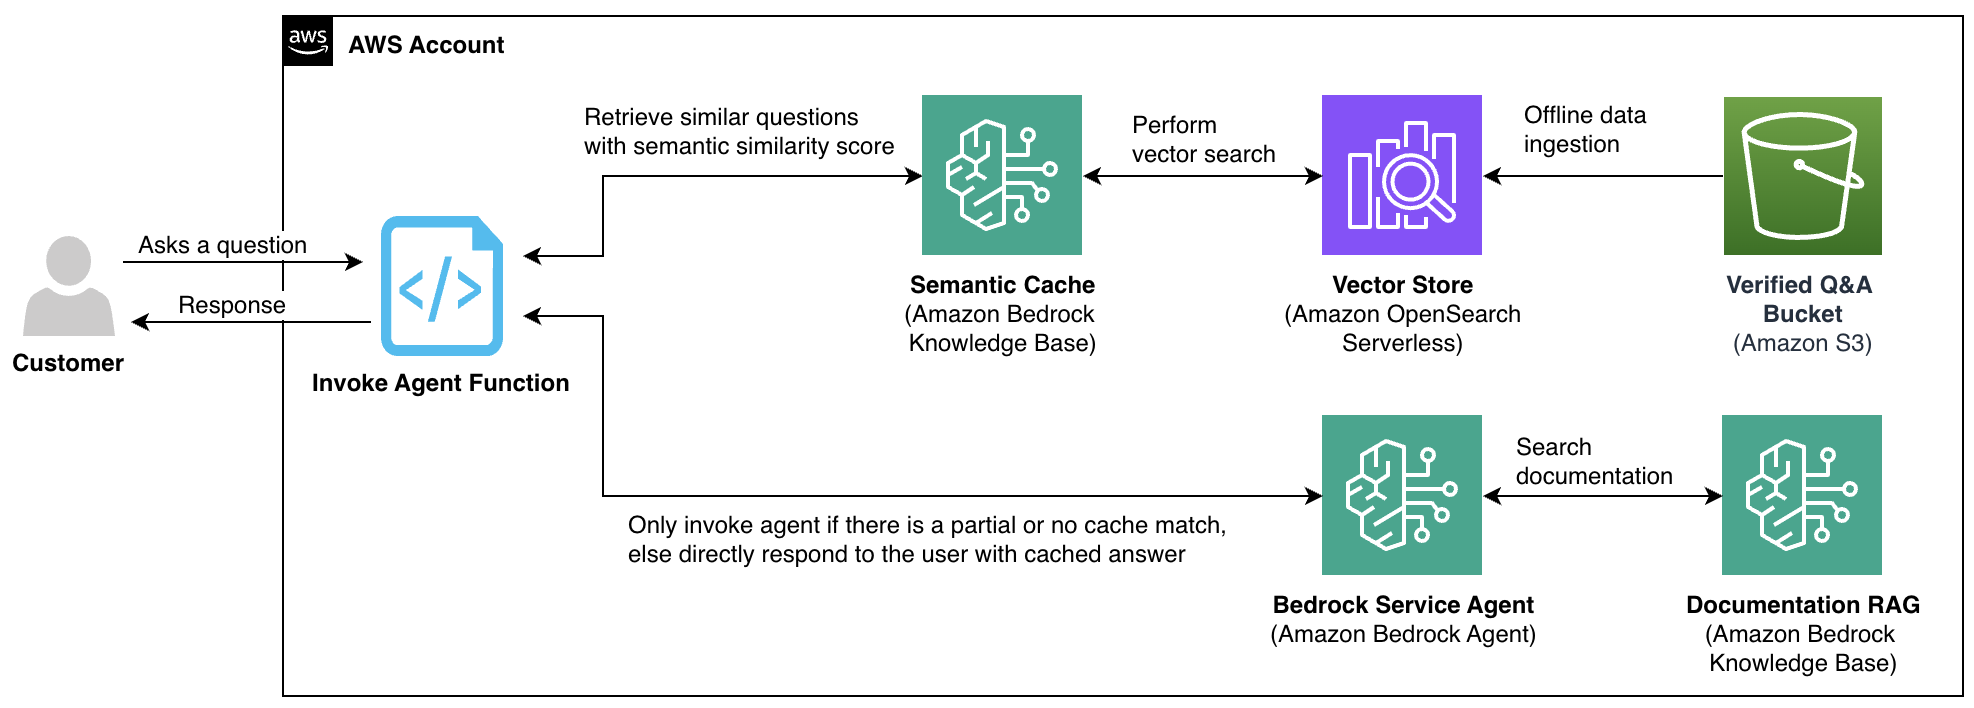

The system uses semantic similarity matching to either: 
1. directly serve pre-verified answers for highly similar queries (>80% match), 
2. guide the LLM with few-shot examples for partial matches (60-80% similarity), or
3. fall back to standard agent processing for unique queries.

This implementation demonstrates how to achieve improved accuracy, reduced costs, and lower latency while maintaining the flexibility of LLM-powered responses.

Through this notebook, we will:
1. Install and import necessary libraries
2. Set up two Amazon Bedrock Knowledge Bases
3. Create and configure a simple [Bedrock Agent](https://aws.amazon.com/bedrock/agents/) with RAG capabilities
4. Implement a verified semantic cache system
5. Demonstrate the effectiveness of our approach through different test scenarios
6. Clean up all resources to avoid unexpected costs

### 0. Prerequisites
1. Ensure that you have [requested model access](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html) for the following foundation models within the correct AWS region
    - Anthropic Claude Sonnet v1 (Bedrock Model ID: anthropic.claude-3-sonnet-20240229-v1:0)
    - Amazon Titan Text Embeddings v2 (Bedrock Model ID: amazon.titan-embed-text-v2)

### 1. Install & import libraries

In [ ]:
%pip install --force-reinstall -q -r ./requirements.txt > /dev/null 2>&1

In [ ]:
import os
import time
import uuid
import boto3
import json
import requests
import pandas as pd
from knowledge_base import BedrockKnowledgeBase
from agent import AgentsForAmazonBedrock

session = boto3.session.Session()
region = session.region_name
account_id = session.client('sts').get_caller_identity()['Account']
s3_client = boto3.client("s3",region_name=region)
bedrock = boto3.client("bedrock",region_name=region)
bedrock_runtime = boto3.client("bedrock-runtime",region_name=region)
bedrock_agent_client = boto3.client("bedrock-agent",region_name=region)
bedrock_agent_runtime_client = boto3.client("bedrock-agent-runtime",region_name=region)

### 2. Create Amazon Bedrock Knowledge Bases

We need to create two Amazon Bedrock Knowledge Bases: an Agent Knowledge Base and a Cache Knowledge Base.

Let's get started with our Agent Knowledge Base. It will contain some documentation about the Amazon Bedrock Service that our Bedrock Agent can reference using Retrieval Augmented Generation (RAG) when answering user questions.

These may take a few minutes to be created.

In [ ]:
agent_unique_id = str(uuid.uuid4())[:4]
agent_knowledge_base_name = "{}-agent-rag".format(agent_unique_id)
agent_knowledge_base_description = "Knowledge base used by Bedrock Agent"
agent_bucket_name = "{}-agent-rag".format(agent_unique_id)
agent_knowledge_base = BedrockKnowledgeBase(
    kb_name=agent_knowledge_base_name,
    kb_description=agent_knowledge_base_description,
    data_bucket_name=agent_bucket_name,
    chunking_strategy = "FIXED_SIZE", 
    suffix = f'{agent_unique_id}-f'
)

Secondly, our Cache Knowledge Base will contain question-answer pairs for important, frequently asked questions that we have pre-verified. Let's create this knowledge base now.

In [ ]:
cache_unique_id = str(uuid.uuid4())[:4]
cache_knowledge_base_name = "{}-verified-cache".format(cache_unique_id)
cache_knowledge_base_description = "Verified cache for Bedrock Agent System"
cache_bucket_name = "{}-verified-cache".format(cache_unique_id)
cache_knowledge_base = BedrockKnowledgeBase(
    kb_name=cache_knowledge_base_name,
    kb_description=cache_knowledge_base_description,
    data_bucket_name=cache_bucket_name,
    chunking_strategy = "NONE", # We do not want to chunk our question-answer pairs
    suffix = f'{cache_unique_id}-f'
)

### 3. Setup Agent and Agent Knowledge Base

#### 3.1 Download the dataset

Since we are creating an Agent that can answer questions about the Amazon Bedrock Service, we will be ingesting the following Amazon Bedrock User Guide PDF into our knowledge base.

https://aws-blogs-artifacts-public.s3.amazonaws.com/ML-15986/AmazonBedrock_UserGuide.pdf

In [ ]:
url = "https://aws-blogs-artifacts-public.s3.amazonaws.com/ML-15986/AmazonBedrock_UserGuide.pdf"
file_name = "kb_documents/AmazonBedrock_UserGuide.pdf"
os.makedirs("kb_documents", exist_ok=True)
response = requests.get(url)
with open(file_name, "wb") as file:
    file.write(response.content)
print(f"File '{file_name}' has been downloaded.")

#### 3.2 Upload the RAG documents to S3 and sync Agent Knowledge Base

In [ ]:
def upload_directory(path, bucket_name):
    for root, dirs, files in os.walk(path):
        for file in files:
            if "checkpoint" in file: # Skip ipynb checkpoint files
                continue
            if file.endswith(".pdf") or file.endswith(".txt") or file.endswith(".json"):
                file_to_upload = os.path.join(root, file)
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload, bucket_name, file)

upload_directory("kb_documents", agent_bucket_name)

# ensure that the kb is available after creation
time.sleep(30)
# sync knowledge base
agent_knowledge_base.start_ingestion_job()

#### 3.3 Create Amazon Bedrock Agent and associate it with Agent Knowledge Base

Now that we have ingested our dataset into our knowledge base, let's create our agent and associate it with our knowledge base.

In [ ]:
# Create Agent
agent_kb_id = agent_knowledge_base.get_knowledge_base_id()
agent_kb_arn = f"arn:aws:bedrock:{region}:{account_id}:knowledge-base/{agent_kb_id}"
agent_name = "AmazonBedrockServiceAgent"
agent_description = "An agent that can answer questions about Amazon Bedrock service."
agent_instruction = """You are the Amazon Bedrock Agent. You have access to a knowledge base with information about the Amazon Bedrock service on AWS. Use it to answer questions."""
agent_foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
agents_handler = AgentsForAmazonBedrock()
agent_id = agents_handler.create_agent(agent_name, agent_description, agent_instruction, [agent_foundation_model], kb_arns=[agent_kb_arn])
print("Created agent with ID: " + agent_id)

# Prepare agent test alias
bedrock_agent_client.prepare_agent(
    agentId=agent_id
)

# Wait for agent to be prepared
time.sleep(30)

#### 3.4 Create and test the invoke agent function

In [ ]:
def invoke_agent(query, session_id, enable_trace=False, session_state=dict()):
    end_session:bool = False
    
    # invoke the agent API
    agentResponse = bedrock_agent_runtime_client.invoke_agent(
        inputText=query,
        agentId=agent_id,
        agentAliasId="TSTALIASID", # Test alias
        sessionId=session_id,
        enableTrace=enable_trace, 
        endSession=end_session,
        sessionState=session_state
    )
    
    if enable_trace:
        logger.info(pprint.pprint(agentResponse))
    
    event_stream = agentResponse['completion']
    try:
        for event in event_stream:        
            if 'chunk' in event:
                data = event['chunk']['bytes']
                if enable_trace:
                    logger.info(f"Final answer ->\n{data.decode('utf8')}")
                agent_answer = data.decode('utf8')
                end_event_received = True
                return agent_answer
                # End event indicates that the request finished successfully
            elif 'trace' in event:
                if enable_trace:
                    logger.info(json.dumps(event['trace'], indent=2))
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)

In [ ]:
%%time
invoke_agent("What are the dates for reinvent 2024?", session_id="test")

### 4. Ingest verified question-answer pairs to Cache Knowledge Base

Now that we have set up our agent, let's focus on our read-only semantic cache. 

We have already setup our cache knowledge base infrastructure. Moving forward, we need to create a dataset of verified question-answer pairs and ingest them into our cache knowledge base.

#### 4.1 Curate verified answers for known frequently asked questions



In [ ]:
cache_raw_data = {
    'question_id': ['Q001', 'Q002'],
    'question': [
        'What are the dates for reinvent 2024?',
        'What was the biggest new feature announcement for Bedrock Agents during reinvent 2024?'
    ],
    'ground_truth_answer': [
        'The AWS re:Invent conference was held from December 2-6 in 2024.',
        'During re:Invent 2024, one of the headline new feature announcements for Bedrock Agents was the custom orchestrator. This key feature allows users to implement their own orchestration strategies through AWS Lambda functions, providing granular control over task planning, completion, and verification while enabling real-time adjustments and reusability across multiple agents.'
    ]
}

cache_df = pd.DataFrame(cache_raw_data)
cache_df.head()

#### 4.2 Reorganize verified answers to S3 objects with corresponding metadata files

In [ ]:
# Create base directory
os.makedirs("cache_documents", exist_ok=True)

# Iterate through the dataframe
for index, row in cache_df.iterrows():    
    # Create and write the question file
    question_filename = os.path.join("cache_documents", f"{row['question_id']}.txt")
    with open(question_filename, 'w') as f:
        f.write(row['question'].lower())
    
    # Create and write the metadata file
    metadata_filename = f"{question_filename}.metadata.json"
    metadata_content = {
        "metadataAttributes": {
            "answer": row['ground_truth_answer']
        }
    }
    
    with open(metadata_filename, 'w') as f:
        json.dump(metadata_content, f, indent=2)

print("Files created successfully!")

#### 4.3 Upload the cache documents to S3 and sync Cache Knowledge Base

In [ ]:
upload_directory("cache_documents", cache_bucket_name)

# ensure that the kb is available after creation
time.sleep(15)

# sync knowledge base
cache_knowledge_base.start_ingestion_job()

time.sleep(15)

#### 4.4 Create and test the invoke agent function with verified cache

In [ ]:
def invoke_agent_with_verified_cache(query, session_id=None, enable_trace=False, session_state=dict()):
    if not session_id:
        session_id = str(uuid.uuid4())
    
    # Define confidence thresholds
    strong_match_threshold = 0.8
    partial_match_threshold = 0.6

    try:
        # Query the cache knowledge base
        cache_response = bedrock_agent_runtime_client.retrieve(
            knowledgeBaseId=cache_knowledge_base.get_knowledge_base_id(),
            retrievalQuery={'text': query.lower()},
            retrievalConfiguration={
                'vectorSearchConfiguration': {
                    'numberOfResults': 1
                }
            }
        )
        
        # Check if there are any results
        if cache_response.get('retrievalResults'):
            top_result = cache_response['retrievalResults'][0]
            score = top_result['score']
            cached_answer = top_result['metadata']['answer']

            # Strong match - return cached answer directly
            if score >= strong_match_threshold:
                print(f"Cache semantic similarity log: Strong match with score {score}")
                return cached_answer
            
            # Partial match - pass cached answer through promptSessionAttributes as a few-shot example
            elif score >= partial_match_threshold:
                print(f"Cache semantic similarity log: Partial match with score {score}")
                verified_context = (
                    "<SimilarQuestionAnswer>"
                    f"Here is a previous question that is similar to the user's current question: \"{top_result['content']['text']}\", "
                    "along with the verified answer: "
                    f"\n{top_result['metadata']['answer']}"
                    "</SimilarQuestionAnswer>"
                    "<Instruction>"
                    "Guidelines for using this information:"
                    "\n- You may use or modify this response to answer the current question"
                    "\n- Do not reference or mention that this information came from a cache"
                    "\n- Ensure the response aligns with the current query context"
                    "\n- Maintain accuracy while adapting the information as needed"
                    "</Instruction>"
                )                
                session_state['promptSessionAttributes'] = {
                    'verified_context': verified_context
                }
            else:
                print(f"Cache semantic similarity log: No match with score {score}")
                session_state = dict()
        else:
            print(f"Cache semantic similarity log: No match")
    except Exception as e:
        print(f"Cache lookup error: {str(e)}")

    # For partial matches and no matches, use the existing invoke_agent function
    return invoke_agent(query, session_id, enable_trace, session_state)

### 5. Evaluate results

Our Bedrock Agent and verified cache layer is all set up. Let's evaluate all 3 cases below.

#### 5.1 Strong semantic match

If the semantic similarity score of the cached results is greater than the strong match threshold, we expect an answer within less than one second as we do not need to invoke our Bedrock Agent at all.

In [ ]:
%%time
invoke_agent_with_verified_cache("What were some new features announced for Bedrock Agents during reinvent 2024?") 

#### 5.2 Partial semantic match

If the semantic similarity score is less than the strong match threshold, but greater than the partial match threshold, we invoke the agent using the verified question-answer pair as a few shot example. The agent should be able to answer the following question even though the answer is not present in the knowledge base.

In [ ]:
%%time
invoke_agent_with_verified_cache("What are the newest features for Bedrock Agents?") 

#### 5.3 No semantic match

If the semantic similarity score of the retrieved result is less than the partial match threshold, or if no similar results are retrieved from the cache knowledge base, we will invoke the agent normally without adding any additional context. 

Here, we expect the agent to either tell us that the answer is unavailable in the knowledge base, or to make up a plausible answer (i.e. hallucinate).

In [ ]:
%%time
invoke_agent_with_verified_cache("Tell me about a new feature for Amazon Bedrock Agents") 

### 6. Clean up resources

Run the following cells to delete all the resources created to avoid incurring unnecessary costs.

In [ ]:
# Delete agent
agents_handler.delete_agent(agent_name)

In [ ]:
# Delete Bedrock Knowledge Bases and S3 buckets
agent_knowledge_base.delete_kb(delete_s3_bucket=True, delete_iam_roles_and_policies=True, delete_lambda_function=True)
cache_knowledge_base.delete_kb(delete_s3_bucket=True, delete_iam_roles_and_policies=True, delete_lambda_function=True)